# Your Final Project Title

- Vicky Xie: LMAO
- member 2: put their contribution here
- member 3: put their contribution here
- ...

In [52]:
# Instructions

- Introduction: Briefly describe what your project is about.
- Research Questions: Pose research questions that are related to communication studies.
- Dataset Description: Introduce your chosen dataset. Give a detailed description of what this dataset is about, and use the df.describe() function to provide a basic statistical description of the dataset. You can choose a dataset from surveys, social media, or news articles. Make sure your research questions and the chosen dataset are matching.
- Preprocessing: Carry out the preprocessing of your chosen dataset, and justify why those preprocessing steps are related to your research questions.
- Analysis: Choose 2-3 analyses that you have learned in this class (e.g., sentiment analysis, name entity recognition, part-of-speech tagging, collocation analysis, topic modeling, network analysis, etc.). Justify why you choose these analyses. If there is only one method that suits your research goal the best, you can use one method only but make sure you use it at least twice (i.e., you have two different but related research questions that both involve this method).
- Visualization: Use matplotlib and/or seaborn to visualize your results.
- Results/Findings: Provide text descriptions for your results/findings.
- Contribution: Specify each group member's contributions.

# Introduction
- what is this about?
- lmao

# Research Questions
- Tbh we could do sentiment analysis with different tragedies, we can just pull up another csv and cross analyze with sentiment analysis.
- Relate this to communicattion during tragedies? Maybe coping mechanisms idk?
- Other Tragedies we can pull from:
  - Sandy Hurricane 2012
  - Oklahoma Tornado Season 2013
  - West Texas Explosion 2013
  - Alberta Floods 2013
  - Queensland Floods 2013

# Dataset Description
- So obv we used the 2013 Boston Bombing csv
- do we yeet the df here? cuz we'd have to have a huge asf import list; where would we like to position that? It has to run in order

In [60]:
import pandas as pd

df=pd.read_csv("2013_Boston_Bombings-ontopic_offtopic.csv")
df.describe()

,tweet id,tweet,label
count,10012,10012,10012
unique,10012,9226,2
top,'325208201740029952',RT @DannyAmendola: I will DONATE $100 for EVER...,on-topic
freq,1,34,5648


In [4]:
# maybe delete this later
df.columns

Index(['tweet id', ' tweet', ' label'], dtype='object')

In [66]:
# WHO MADE THESE COLUMNS AHDKSHDKSH WHY ARE THERE SPACES

# Preprocessing
- Preprocessing removes all unneeded bits of information???

In [64]:
# text cleaning
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'#', '', text) # remove hashtag
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    return text.strip()

# apply the function to dataframe
df['clean_text'] = df[' tweet'].apply(clean_text)

# test to make sure it worked
df['clean_text']

0        Funny how I got twenty minutes of sleep last n...
1                                  I just wanna go outside
2        This is fucking crazy. Suspect 2 has like 2 ho...
3        oops, someone doesn't like to be told he's a l...
4                    Let me love you you know who else too
                               ...                        
10007    RT : Boston bombing suspects’ dad says sons we...
10008    Like the boston marathon, on a episode peter h...
10009    RT : MUST WATCH: Bruins fans sing emotional Na...
10010    RT : So that Boston bombing was fake just like...
10011    RT : Both FBI and al Qaeda struggling to ident...
Name: clean_text, Length: 10012, dtype: object

# Analysis
- Analysis: Choose 2-3 analyses that you have learned in this class (e.g., sentiment analysis, name entity recognition, part-of-speech tagging, collocation analysis, topic modeling, network analysis, etc.). Justify why you choose these analyses. If there is only one method that suits your research goal the best, you can use one method only but make sure you use it at least twice (i.e., you have two different but related research questions that both involve this method).
- Ok so obv Sentiment Analysis

# Sentiment Analysis
- Aight add your explanations in here

In [65]:
# mass install our stuff
!pip install textblob
!pip install nltk 
!pip install -U textblob

In [29]:
# Import necessary libraries
import pandas as pd
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import re

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [14]:
# Hehe sentiment scores?

In [70]:
# Define a function for sentiment analysis using TextBlob
def get_sentiment_textblob(text):
    """
    this function takes text as the input and calculates the sentiment score of this given text.
    """
    sentiment = TextBlob(text).sentiment.polarity
    if sentiment > 0:
        return "Positive"
    elif sentiment < 0:
        return "Negative"
    else:
        return "Neutral"

# get continuous textblob sentiment scores
def get_sent_textblob_cont(text):
    return TextBlob(text).sentiment.polarity

# Define a function for sentiment analysis using NLTK's Vader
def get_sentiment_vader(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    if sentiment['compound'] > 0.05:
        return "Positive"
    elif sentiment['compound'] < -0.05:
        return "Negative"
    else:
        return "Neutral"
    
# get continuous textblob sentiment scores
def get_sent_vader_cont(text):
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)['compound']

In [71]:
df['sentiment_textblob'] = df['clean_text'].apply(get_sentiment_textblob)
df[["clean_text", "sentiment_textblob"]]

,clean_text,sentiment_textblob
0,Funny how I got twenty minutes of sleep last n...,Positive
1,I just wanna go outside,Neutral
2,This is fucking crazy. Suspect 2 has like 2 ho...,Negative
3,"oops, someone doesn't like to be told he's a l...",Neutral
4,Let me love you you know who else too,Positive
...,...,...
10007,RT : Boston bombing suspects’ dad says sons we...,Negative
10008,"Like the boston marathon, on a episode peter h...",Neutral
10009,RT : MUST WATCH: Bruins fans sing emotional Na...,Negative
10010,RT : So that Boston bombing was fake just like...,Negative


In [72]:
df['sent_textblob_cont'] = df['clean_text'].apply(get_sent_textblob_cont)
df[["clean_text", "sentiment_textblob", "sent_textblob_cont"]]

,clean_text,sentiment_textblob,sent_textblob_cont
0,Funny how I got twenty minutes of sleep last n...,Positive,0.166667
1,I just wanna go outside,Neutral,0.000000
2,This is fucking crazy. Suspect 2 has like 2 ho...,Negative,-0.600000
3,"oops, someone doesn't like to be told he's a l...",Neutral,0.000000
4,Let me love you you know who else too,Positive,0.500000
...,...,...,...
10007,RT : Boston bombing suspects’ dad says sons we...,Negative,-0.250000
10008,"Like the boston marathon, on a episode peter h...",Neutral,0.000000
10009,RT : MUST WATCH: Bruins fans sing emotional Na...,Negative,-0.050000
10010,RT : So that Boston bombing was fake just like...,Negative,-0.500000


In [74]:
# The code below runs I swear it just takes friggin forever so chug a celcius while you wait

In [73]:
df['sentiment_vader'] = df['clean_text'].apply(get_sentiment_vader)
df[["clean_text", "sentiment_textblob", "sentiment_vader"]]

,clean_text,sentiment_textblob,sentiment_vader
0,Funny how I got twenty minutes of sleep last n...,Positive,Positive
1,I just wanna go outside,Neutral,Neutral
2,This is fucking crazy. Suspect 2 has like 2 ho...,Negative,Negative
3,"oops, someone doesn't like to be told he's a l...",Neutral,Negative
4,Let me love you you know who else too,Positive,Positive
...,...,...,...
10007,RT : Boston bombing suspects’ dad says sons we...,Negative,Neutral
10008,"Like the boston marathon, on a episode peter h...",Neutral,Negative
10009,RT : MUST WATCH: Bruins fans sing emotional Na...,Negative,Positive
10010,RT : So that Boston bombing was fake just like...,Negative,Negative


In [75]:
# Apply sentiment analysis functions
df['sent_vader_cont'] = df['clean_text'].apply(get_sent_vader_cont)
df[["clean_text", "sentiment_textblob", "sent_textblob_cont", "sentiment_vader", "sent_vader_cont"]]

,clean_text,sentiment_textblob,sent_textblob_cont,sentiment_vader,sent_vader_cont
0,Funny how I got twenty minutes of sleep last n...,Positive,0.166667,Positive,0.6597
1,I just wanna go outside,Neutral,0.000000,Neutral,0.0000
2,This is fucking crazy. Suspect 2 has like 2 ho...,Negative,-0.600000,Negative,-0.3962
3,"oops, someone doesn't like to be told he's a l...",Neutral,0.000000,Negative,-0.6715
4,Let me love you you know who else too,Positive,0.500000,Positive,0.6369
...,...,...,...,...,...
10007,RT : Boston bombing suspects’ dad says sons we...,Negative,-0.250000,Neutral,0.0000
10008,"Like the boston marathon, on a episode peter h...",Neutral,0.000000,Negative,-0.4939
10009,RT : MUST WATCH: Bruins fans sing emotional Na...,Negative,-0.050000,Positive,0.1531
10010,RT : So that Boston bombing was fake just like...,Negative,-0.500000,Negative,-0.1531


In [44]:
# wtf does this look like
df

,tweet id,tweet,label,cleaned_text,sentiment_textblob,clean_text,sent_textblob_cont,sentiment_vader,sent_vader_cont
0,'325208201740029952',Funny how I got twenty minutes of sleep last n...,off-topic,Funny how I got twenty minutes of sleep last n...,Positive,Funny how I got twenty minutes of sleep last n...,0.166667,Positive,0.6597
1,'325301650791215106',I just wanna go outside,off-topic,I just wanna go outside,Neutral,I just wanna go outside,0.000000,Neutral,0.0000
2,'325182966332530688',This is fucking crazy. Suspect # 2 has like 2 ...,on-topic,This is fucking crazy Suspect 2 has like 2 hou...,Negative,This is fucking crazy. Suspect 2 has like 2 ho...,-0.600000,Negative,-0.3962
3,'324654539850539009',"@J_Adams91 oops, someone doesn't like to be to...",off-topic,oops someone doesn t like to be told he s a ly...,Neutral,"oops, someone doesn't like to be told he's a l...",0.000000,Negative,-0.6715
4,'323630018536275968',Let me love you @GavinQuin you know who else too,off-topic,Let me love you you know who else too,Positive,Let me love you you know who else too,0.500000,Positive,0.6369
...,...,...,...,...,...,...,...,...,...
10007,'325357142418792448',RT @ISCOSEU: Boston bombing suspects’ dad says...,on-topic,RT Boston bombing suspects dad says sons were ...,Negative,RT : Boston bombing suspects’ dad says sons we...,-0.250000,Neutral,0.0000
10008,'324425973623816193',"Like the boston marathon, on a episode peter h...",on-topic,Like the boston marathon on a episode peter ha...,Neutral,"Like the boston marathon, on a episode peter h...",0.000000,Negative,-0.4939
10009,'324674851572965376',RT @SportsCenter: MUST WATCH: Bruins fans sing...,on-topic,RT MUST WATCH Bruins fans sing emotional Natio...,Negative,RT : MUST WATCH: Bruins fans sing emotional Na...,-0.050000,Positive,0.1531
10010,'325378699237142528',RT @iamPink_Lipss: So that Boston bombing was ...,on-topic,RT So that Boston bombing was fake just like t...,Negative,RT : So that Boston bombing was fake just like...,-0.500000,Negative,-0.1531


In [45]:
# aight so apparently i need to find some way to filter this sh to only on topic labels bet

# Visualization 
- Use matplotlib and/or seaborn to visualize your results.
- Feast your eyes
- You're welcome

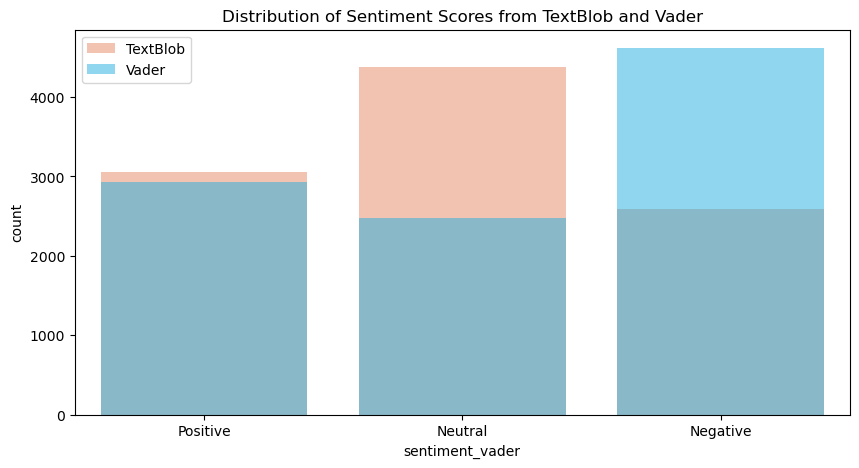

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(x="sentiment_textblob", data=df, label="TextBlob", color='coral', alpha=0.5)
sns.countplot(x="sentiment_vader", data=df, label="Vader", color='deepskyblue', alpha=0.5)
plt.legend()
plt.title('Distribution of Sentiment Scores from TextBlob and Vader')
plt.show()

In [51]:
# ok  so I aint touching anything until I figure this sh out gl kadjhkjsahdashkhsaklkhdksah but that large asf portion is a sentiment analysis but I cant do over time bc for some reason this csv didn't include timestamps bc wtf

# Results/Findings
- lmao good luck